In [1]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.tree import ExtraTreeRegressor
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut
seed=911
###########import packages##########
import catboost
import xgboost
import lightgbm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import *
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  *

In [2]:
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
def gridsearch(model,param,algorithm_name,X_train,y_train,X_test,y_test):
    grid = GridSearchCV(model,param_grid=param,scoring='neg_mean_absolute_error',cv=10,n_jobs=-1,verbose=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    ####Train####
    prediction_train = best_model.predict(X_train)
    real_train=y_train.values
    prediction_train_series=pd.Series(prediction_train)
    real_train_series=pd.Series(real_train)
    corr_ann_train = round(prediction_train_series.corr(real_train_series), 5)
    error_val_train= compute_mae_mse_rmse(prediction_train,real_train)
    ####test####
    prediction_test = best_model.predict(X_test)
    real_test=y_test.values
    prediction_test_series=pd.Series(prediction_test)
    real_test_series=pd.Series(real_test)
    corr_ann_test = round(prediction_test_series.corr(real_test_series), 5)
    error_val_test= compute_mae_mse_rmse(prediction_test,real_test)
    print(algorithm_name)
    best_score=grid.best_score_
    print('Best Regressor:',grid.best_params_,'Best Score:', best_score)
    print(error_val_test)
    print('R2 TEST',error_val_test[3])
    fig=plt.figure()
    ax = fig.add_subplot(111)
    x_y_x=np.arange(-4,4,0.01)
    x_y_y=np.arange(-4,4,0.01)
    ax.scatter(prediction_train,real_train,c='blue',label='Train',alpha=0.25)
    ax.scatter(prediction_test,real_test,c='red',label='Test',alpha=0.75)
    ax.plot(x_y_x,x_y_y,c='black')
    plt.legend()
    plt.xlabel('Predicted_log_(Decay_Rate) (mV h-1)')
    plt.ylabel('Real_log_(Decay_Rate) (mV h-1)')
    return best_model,error_val_test[3]

In [3]:
fl = open(r'./database_full_st_for_inter.pkl','rb')
database_full=pickle.load(fl)
data_input_full=database_full.iloc[:,0:55]
data_output_full=database_full.iloc[:,55]
X_train,X_test,y_train,y_test=train_test_split(data_input_full,data_output_full,test_size=0.1,random_state=seed)

XGBoost
Best Regressor: {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 11, 'n_estimators': 100, 'reg_alpha': 1e-05, 'reg_lambda': 0, 'subsample': 0.45} Best Score: -0.3949566628514379
(0.2622378115122196, 0.09449557273980007, 0.30740132195519276, 0.8566708797913729)
R2 TEST 0.8566708797913729


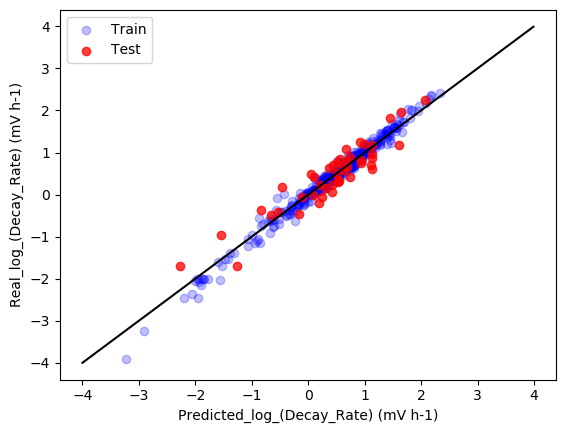

In [4]:
model_XGRegressor=XGBRegressor(random_state=1)
param_xg={
# 'booster':['gbtree'],
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[100,200,400],
# 'max_depth':[3,5,7,9,11,13,-1],
# 'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
# 'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
# 'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
'booster': ['gbtree'], 'learning_rate': [0.05], 'max_depth': [11], 'n_estimators': [100], 'reg_alpha': [1e-05], 'reg_lambda': [0], 'subsample': [0.45 ]   
}
XG_full,XG_full_score=gridsearch(model_XGRegressor,param_xg,'XGBoost',X_train,y_train,X_test,y_test)

D:\Anaconda\envs\pdpbox\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


Random Forest
Best Regressor: {'criterion': 'mae', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 400} Best Score: -0.38572838869533793
(0.2620236353939674, 0.1077132652633999, 0.3281969915514155, 0.8297489681442113)
R2 TEST 0.8297489681442113


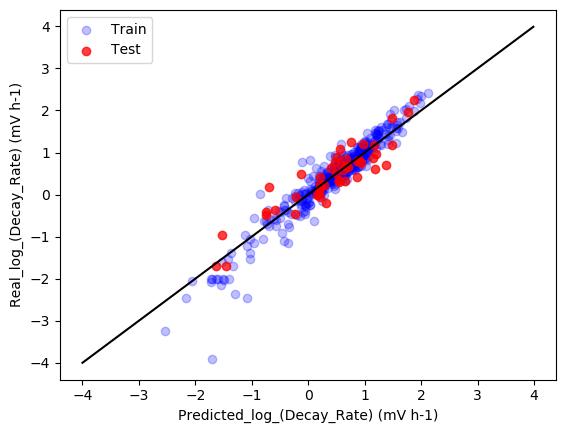

In [5]:
###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
###########defining the parameters dictionary##########
param_RF = {
# 'n_estimators':[50,100,200,400,None],
# 'max_depth':[3,5,7,9,11,None],
# 'criterion':['mse','mae'],
# 'max_features':['auto','sqrt','log2']
'criterion': ['mae'], 'max_depth': [11], 'max_features': ['auto'], 'n_estimators': [400]
}
RF_full,RF_full_score=gridsearch(model_RandomForestRegressor,param_RF,'Random Forest',X_train,y_train,X_test,y_test)

D:\Anaconda\envs\pdpbox\lib\site-packages\sklearn\ensemble\_gb.py:297: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,


GradientBoost
Best Regressor: {'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 100} Best Score: -0.3930309876521968
(0.23716913147133842, 0.08930357537127274, 0.29883703815168683, 0.8024420504640883)
R2 TEST 0.8024420504640883


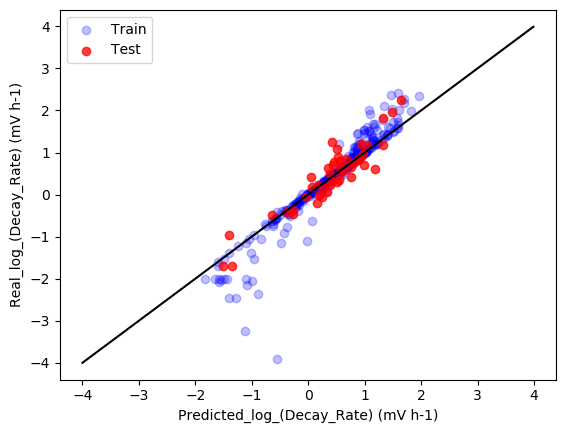

In [6]:
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
###########defining the parameters dictionary##########
param_GB = {
# 'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
# 'n_estimators':[50,100,200,400],
# 'max_depth':[3,5,7,9,11,13,16],
# 'criterion':['friedman_mse','mae','mse'],
# 'max_features':['auto','sqrt','log2'],
# 'loss':['ls', 'lad', 'huber', 'quantile']
    'criterion': ['friedman_mse'], 'learning_rate': [0.05], 'loss': ['lad'], 'max_depth': [9], 'max_features': ['auto'], 'n_estimators': [100]
}
GB_full,GB_full_score=gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost',X_train,y_train,X_test,y_test)

In [7]:
import math
from pdpbox.pdp_calc_utils import _calc_ice_lines_inter
from pdpbox.pdp import pdp_isolate, PDPInteract
from pdpbox.utils import (_check_model, _check_dataset, _check_percentile_range, _check_feature,
                    _check_grid_type, _check_memory_limit, _make_list,
                    _calc_memory_usage, _get_grids, _get_grid_combos, _check_classes)
from joblib import Parallel, delayed

def pdp_multi_interact(model, dataset, model_features, features, 
                    num_grid_points=None, grid_types=None, percentile_ranges=None, grid_ranges=None, cust_grid_points=None, 
                    cust_grid_combos=None, use_custom_grid_combos=False,
                    memory_limit=0.9, n_jobs=8, predict_kwds=None, data_transformer=None):

    def _expand_default(x, default, length):
        if x is None:
            return [default] * length
        return x

    def _get_grid_combos(feature_grids, feature_types):
        grids = [np.array(list(feature_grid),dtype=np.float16) for feature_grid in feature_grids]
        for i in range(len(feature_types)):
            if feature_types[i] == 'onehot':
                grids[i] = np.eye(len(grids[i])).astype(int).tolist()
        return np.stack(np.meshgrid(*grids,copy=bool), -1).reshape(-1, len(grids))

    if predict_kwds is None:
        predict_kwds = dict()

    nr_feats = len(features)

    # check function inputs
    n_classes, predict = _check_model(model=model)
    _check_dataset(df=dataset)
    _dataset = dataset.copy()

    # prepare the grid
    pdp_isolate_outs = []
    if use_custom_grid_combos:
        grid_combos = cust_grid_combos
        feature_grids = []
        feature_types = []
    else:
        num_grid_points = _expand_default(x=num_grid_points, default=10, length=nr_feats)
        grid_types = _expand_default(x=grid_types, default='percentile', length=nr_feats)
        for i in range(nr_feats):
            _check_grid_type(grid_type=grid_types[i])

        percentile_ranges = _expand_default(x=percentile_ranges, default=None, length=nr_feats)
        for i in range(nr_feats):
            _check_percentile_range(percentile_range=percentile_ranges[i])

        grid_ranges = _expand_default(x=grid_ranges, default=None, length=nr_feats)
        cust_grid_points = _expand_default(x=cust_grid_points, default=None, length=nr_feats)

        _check_memory_limit(memory_limit=memory_limit)

        pdp_isolate_outs = []
        for idx in range(nr_feats):
            pdp_isolate_out = pdp_isolate(
                model=model, dataset=_dataset, model_features=model_features, feature=features[idx],
                num_grid_points=num_grid_points[idx], grid_type=grid_types[idx], percentile_range=percentile_ranges[idx],
                grid_range=grid_ranges[idx], cust_grid_points=cust_grid_points[idx], memory_limit=memory_limit,
                n_jobs=n_jobs, predict_kwds=predict_kwds, data_transformer=data_transformer)
            pdp_isolate_outs.append(pdp_isolate_out)

        if n_classes > 2:
            feature_grids = [pdp_isolate_outs[i][0].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i][0].feature_type  for i in range(nr_feats)]
        else:
            feature_grids = [pdp_isolate_outs[i].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i].feature_type  for i in range(nr_feats)]

        grid_combos = _get_grid_combos(feature_grids, feature_types)

    feature_list = []
    for i in range(nr_feats):
        feature_list.extend(_make_list(features[i]))

    # Parallel calculate ICE lines
    true_n_jobs = _calc_memory_usage(
        df=_dataset, total_units=len(grid_combos), n_jobs=n_jobs, memory_limit=memory_limit)

    grid_results = Parallel(n_jobs=true_n_jobs)(delayed(_calc_ice_lines_inter)(
        grid_combo, data=_dataset, model=model, model_features=model_features, n_classes=n_classes,
        feature_list=feature_list, predict_kwds=predict_kwds, data_transformer=data_transformer)
                                                for grid_combo in grid_combos)

    ice_lines = pd.concat(grid_results, axis=0).reset_index(drop=True)
    pdp = ice_lines.groupby(feature_list, as_index=False).mean()

    # combine the final results
    pdp_interact_params = {'n_classes': n_classes, 
                        'features': features, 
                        'feature_types': feature_types,
                        'feature_grids': feature_grids}
    if n_classes > 2:
        pdp_interact_out = []
        for n_class in range(n_classes):
            _pdp = pdp[feature_list + ['class_%d_preds' % n_class]].rename(
                columns={'class_%d_preds' % n_class: 'preds'})
            pdp_interact_out.append(
                PDPInteract(which_class=n_class,
                            pdp_isolate_outs=[pdp_isolate_outs[i][n_class] for i in range(nr_feats)],
                            pdp=_pdp, **pdp_interact_params))
    else:
        pdp_interact_out = PDPInteract(
            which_class=None, pdp_isolate_outs=pdp_isolate_outs, pdp=pdp, **pdp_interact_params)

    return pdp_interact_out
print('ready')

ready


In [8]:
def center(arr): return arr - np.mean(arr)
import itertools
def compute_f_vals(mdl, X, features, selectedfeatures, num_grid_points=10, use_data_grid=False):
    f_vals = {}
    data_grid = None
    if use_data_grid:
        data_grid = X[selectedfeatures].values
    # Calculate partial dependencies for full feature set
    p_full = pdp_multi_interact(mdl, X, features, selectedfeatures, 
                                num_grid_points=[num_grid_points] * len(selectedfeatures),
                                cust_grid_combos=data_grid,
                                use_custom_grid_combos=use_data_grid)
    f_vals[tuple(selectedfeatures)] = center(p_full.pdp.preds.values)
    grid = p_full.pdp.drop('preds', axis=1)
    # Calculate partial dependencies for [1..SFL-1]
    for n in range(1, len(selectedfeatures)):
        for subsetfeatures in itertools.combinations(selectedfeatures, n):
            if use_data_grid:
                data_grid = X[list(subsetfeatures)].values
            p_partial = pdp_multi_interact(mdl, X, features, subsetfeatures, 
                                        num_grid_points=[num_grid_points] * len(selectedfeatures),
                                        cust_grid_combos=data_grid,
                                        use_custom_grid_combos=use_data_grid)
            p_joined = pd.merge(grid, p_partial.pdp, how='left')
            f_vals[tuple(subsetfeatures)] = center(p_joined.preds.values)
    return f_vals
def compute_h_val(f_vals, selectedfeatures):
    denom_els = f_vals[tuple(selectedfeatures)].copy()
    numer_els = f_vals[tuple(selectedfeatures)].copy()
    sign = -1.0
    for n in range(len(selectedfeatures)-1, 0, -1):
        for subfeatures in itertools.combinations(selectedfeatures, n):
            print(tuple(subfeatures))
            numer_els += sign * f_vals[tuple(subfeatures)]
        sign *= -1.0
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan
def compute_h_val_any(f_vals, allfeatures, selectedfeature):
    otherfeatures = list(allfeatures)
    otherfeatures.remove(selectedfeature)
    denom_els = f_vals[tuple(allfeatures)].copy()
    numer_els = denom_els.copy()
    numer_els -= f_vals[(selectedfeature,)]
    numer_els -= f_vals[tuple(otherfeatures)]
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan
def compute_interactions(model,X_train,feature_all,feature_select_list):  
    result_dict={}
    for i in range(len(feature_select_list)):
        for j in range(len(feature_select_list)):
            if i<j :
                print(i,j)
                try:
                    current_features=[feature_select_list[i],feature_select_list[j]]
                    f_vals=compute_f_vals(model, X_train, feature_all,current_features) 
                    result_dict[tuple(current_features)]=compute_h_val(f_vals,current_features)
                except:
                    result_dict[tuple(current_features)]=0
                print(result_dict[tuple(current_features)])
    return result_dict

In [9]:
XG_DICT=compute_interactions(XG_full,data_input_full,data_input_full.columns,list(data_input_full.columns))

0 1
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Number',)
0.004536609777924628
0 2
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Period',)
0.008451227836151412
0 3
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Group',)
0.018001387042206687
0 4
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Ionization Potential',)
0.019737075551323188
0 5
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Electronegativity',)
0.035045545508780106
0 6
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Number of d electrons',)
0.10332740460088008
0 7
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Radius',)
0.019733444809699865
0 8
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.11956613411841724
0 9
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Atomic Number',)
0.009749300171627088
0 10
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Period',)
1.7830506799462763

('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.012066661099557943
1 34
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.01182353648413151
1 35
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
1 36
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.014858671385482879
1 37
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Time (min)',)
0.0118470188021108
1 38
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Still/Strring (0/1)',)
0.05432978360055492
1 39
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
6.642813367810498e-06
1 40
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.04158065515671752
1 41
('Metal_Dopant_1 Atomic Number',)
('Mixed in Solid or Liquid (0/1)',)
0.02130981467929282
1 42
('Metal_Dopant_1 Atomic Number',)
('Annealing Temperature (Celcius Degree)',)
0.00773184275174776

('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.2073336587877903
3 21
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Electronegativity',)
0.00407562200516983
3 22
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.02183630412626508
3 23
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.04254598607624213
3 24
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.008386859408647345
3 25
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Atomic Number',)
4.273613307744395e-06
3 26
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Period',)
4.273613307744395e-06
3 27
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Group',)
4.273613307744395e-06
3 28
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Ionization Potential',)
4.273613307744395e-06
3 29
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Electronegativity',)
4.273613307744395e-06
3 30
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Number of d electrons',)
4.273613307744395e-06
3 31
('Metal_Dopant_1 Group'

('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Number of d electrons',)
0.0851279595610848
5 7
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Atomic Radius',)
0.14872213103580592
5 8
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.011076270924380745
5 9
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Number',)
7.521535012818336e-06
5 10
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Period',)
2.8244071869792464e-06
5 11
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Group',)
0.07861966646219658
5 12
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Ionization Potential',)
0.015852845518810915
5 13
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Electronegativity',)
0.09515053949619082
5 14
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Number of d electrons',)
0.12264267442375758
5 15
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Radius',)
0.04582783666527166
5 16
('Metal_

('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.009498108617685653
6 41
('Metal_Dopant_1 Number of d electrons',)
('Mixed in Solid or Liquid (0/1)',)
0.07300718116385228
6 42
('Metal_Dopant_1 Number of d electrons',)
('Annealing Temperature (Celcius Degree)',)
0.48980394594103055
6 43
('Metal_Dopant_1 Number of d electrons',)
('Annealing Time (min)',)
0.264982638892499
6 44
('Metal_Dopant_1 Number of d electrons',)
('Annealing Still/Strring (0/1)',)
4.384910242924215e-07
6 45
('Metal_Dopant_1 Number of d electrons',)
('Annealing Atomosphere Inert (0/1)',)
0.0037284611825505187
6 46
('Metal_Dopant_1 Number of d electrons',)
('Annealing Atomosphere Reductive (0/1)',)
0.056261675586536886
6 47
('Metal_Dopant_1 Number of d electrons',)
('Post-processing Acid Wash etc. (0/1)',)
0.03024594823955497
6 48
('Metal_Dopant_1 Number of d electrons',)
('Catalyst Loading (mg cm -2)',)
0.10327982136146602
6 49
('Metal_Dopant_1 Number of d electrons',)
('Su

('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d electrons',)
0.0
8 31
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)
0.0
8 32
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.017675011081935307
8 33
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.06665753755922071
8 34
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.028644348145766756
8 35
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
8 36
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Temperature (Celcius degree)',)
0.037079232610366296
8 37
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Time (min)',)
0.12139150329269163
8 38
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Still/Strring (0/1)',)
0.012054139145501222
8 39
('Metal_Dopant_2 Relative Atomic Mass',)
('Hydrothermal Strong Reductant in Liqu

('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Ionization Potential',)
nan
10 29
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Electronegativity',)
nan
10 30
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Number of d electrons',)
nan
10 31
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Atomic Radius',)
nan
10 32
('Metal_Dopant_2 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
1.931485333134596e-06
10 33
('Metal_Dopant_2 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
4.423602088363035e-07
10 34
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Proportion in Precursor ',)
8.577201245434836e-07
10 35
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Proportion in Precursor ',)
nan
10 36
('Metal_Dopant_2 Period',)
('Hydrothermal Temperature (Celcius degree)',)
5.334990192669333e-07
10 37
('Metal_Dopant_2 Period',)
('Hydrothermal Time (min)',)
3.6023659967346176e-07
10 38
('Metal_Dopant_2 Period',)
('Hydrothermal Still/Strring (0/1)',)
2.5209108710433876e-06
10 39
('Metal_Dopant_2 Period',)
('Hydro

('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Atomic Radius',)
1.436265265889574e-06
12 32
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.07765029692522452
12 33
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.04075704393097264
12 34
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.07060669572114962
12 35
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Proportion in Precursor ',)
1.436265265889574e-06
12 36
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Temperature (Celcius degree)',)
0.04725840598140642
12 37
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Time (min)',)
0.05183869690510763
12 38
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Still/Strring (0/1)',)
0.010665499593965582
12 39
('Metal_Dopant_2 Ionization Potential',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.021215918203815038
12 40
('Metal_Dopa

('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Electronegativity',)
1.3089454681711664e-06
14 30
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Number of d electrons',)
1.3089454681711664e-06
14 31
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Atomic Radius',)
1.3089454681711664e-06
14 32
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.051350640670537975
14 33
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.04941486925288297
14 34
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.04682922611876699
14 35
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Proportion in Precursor ',)
1.3089454681711664e-06
14 36
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Temperature (Celcius degree)',)
0.04952641425158252
14 37
('Metal_Dopant_2 Number of d electrons',)
('Hydrothermal Time (min)',)
0.0481064973133446
14 38
('Meta

('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.15121943122543202
16 34
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.1119384432826934
16 35
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
16 36
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Temperature (Celcius degree)',)
0.03336315822310655
16 37
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Time (min)',)
0.04152202771575685
16 38
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Still/Strring (0/1)',)
0.13467146859935886
16 39
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0005572411430966427
16 40
('Metal_Dopant_3 Relative Atomic Mass',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.023486368324023323
16 41
('Metal_Dopant_3 Relative Atomic Mass',)
('Mixed in Solid or Liquid (0/1)',)
0.08956457903279763
16 42
('Metal_Dopant_3 Relative 

('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.0036776343967492636
19 21
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Electronegativity',)
6.233661399670373e-06
19 22
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.010513619859759165
19 23
('Metal_Dopant_3 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.011087167409911886
19 24
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.036783046242328685
19 25
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Atomic Number',)
0.0
19 26
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Period',)
0.0
19 27
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Group',)
0.0
19 28
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Ionization Potential',)
0.0
19 29
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Electronegativity',)
0.0
19 30
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Number of d electrons',)
0.0
19 31
('Metal_Dopant_3 Group',)
('Metal_Dopant_4 Atomic Radius',)
0.0
19 32
('Metal_Dopant_3 Group',)
('Metal_Dopant_1 

('Metal_Dopant_3 Electronegativity',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.04646414769482322
21 41
('Metal_Dopant_3 Electronegativity',)
('Mixed in Solid or Liquid (0/1)',)
6.51128306048082e-07
21 42
('Metal_Dopant_3 Electronegativity',)
('Annealing Temperature (Celcius Degree)',)
0.02594248366520278
21 43
('Metal_Dopant_3 Electronegativity',)
('Annealing Time (min)',)
0.04951043014429539
21 44
('Metal_Dopant_3 Electronegativity',)
('Annealing Still/Strring (0/1)',)
2.3318888068429535e-06
21 45
('Metal_Dopant_3 Electronegativity',)
('Annealing Atomosphere Inert (0/1)',)
1.7822286514794682e-06
21 46
('Metal_Dopant_3 Electronegativity',)
('Annealing Atomosphere Reductive (0/1)',)
0.010630436452129648
21 47
('Metal_Dopant_3 Electronegativity',)
('Post-processing Acid Wash etc. (0/1)',)
0.3711731474414389
21 48
('Metal_Dopant_3 Electronegativity',)
('Catalyst Loading (mg cm -2)',)
0.018851173275329553
21 49
('Metal_Dopant_3 Electronegativity',)
('Support Material Loading (mg 

('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
0.0
24 30
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d electrons',)
0.0
24 31
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)
0.0
24 32
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.0208597692263065
24 33
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.004984421671923341
24 34
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.00019133063120242372
24 35
('Metal_Dopant_4 Relative Atomic Mass',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
24 36
('Metal_Dopant_4 Relative Atomic Mass',)
('Hydrothermal Temperature (Celcius degree)',)
0.008448570573070083
24 37
('Metal_Dopant_4 Relative Atomic Mass',)
('Hydrothermal Time (min)',)
0.0012100339743264335
24 38
('Metal_Dopant_4 Relative Atomic Mass',)
('Hydrothermal Still/Strring (0/1)',)
1.7793

('Metal_Dopant_4 Group',)
('Hydrothermal Still/Strring (0/1)',)
0.0
27 39
('Metal_Dopant_4 Group',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0
27 40
('Metal_Dopant_4 Group',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0
27 41
('Metal_Dopant_4 Group',)
('Mixed in Solid or Liquid (0/1)',)
0.0
27 42
('Metal_Dopant_4 Group',)
('Annealing Temperature (Celcius Degree)',)
0.0
27 43
('Metal_Dopant_4 Group',)
('Annealing Time (min)',)
0.0
27 44
('Metal_Dopant_4 Group',)
('Annealing Still/Strring (0/1)',)
0.0
27 45
('Metal_Dopant_4 Group',)
('Annealing Atomosphere Inert (0/1)',)
0.0
27 46
('Metal_Dopant_4 Group',)
('Annealing Atomosphere Reductive (0/1)',)
0.0
27 47
('Metal_Dopant_4 Group',)
('Post-processing Acid Wash etc. (0/1)',)
0.0
27 48
('Metal_Dopant_4 Group',)
('Catalyst Loading (mg cm -2)',)
7.239065668330629e-07
27 49
('Metal_Dopant_4 Group',)
('Support Material Loading (mg cm -2)',)
6.606502125787343e-07
27 50
('Metal_Dopant_4 Group',)
('Support is not Carbon (0/1)

('Metal_Dopant_4 Number of d electrons',)
('Stability Test Time (h)',)
2.5865639422396156e-08
31 32
('Metal_Dopant_4 Atomic Radius',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.0
31 33
('Metal_Dopant_4 Atomic Radius',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.0
31 34
('Metal_Dopant_4 Atomic Radius',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.0
31 35
('Metal_Dopant_4 Atomic Radius',)
('Metal_Dopant_4 Proportion in Precursor ',)
nan
31 36
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Temperature (Celcius degree)',)
0.0
31 37
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Time (min)',)
0.0
31 38
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Still/Strring (0/1)',)
0.0
31 39
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.0
31 40
('Metal_Dopant_4 Atomic Radius',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0
31 41
('Metal_Dopant_4 Atomic Radius',)
('Mixed in Solid or Liquid (0/1)',)
0.0
31 42
('Metal_Dopant_4 Atomic Radius

('Metal_Dopant_3 Proportion in Precursor ',)
('Post-processing Acid Wash etc. (0/1)',)
0.030833105671780225
34 48
('Metal_Dopant_3 Proportion in Precursor ',)
('Catalyst Loading (mg cm -2)',)
0.0585450188331342
34 49
('Metal_Dopant_3 Proportion in Precursor ',)
('Support Material Loading (mg cm -2)',)
0.08205876286383404
34 50
('Metal_Dopant_3 Proportion in Precursor ',)
('Support is not Carbon (0/1)',)
0.0014611991417286091
34 51
('Metal_Dopant_3 Proportion in Precursor ',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.029232511749060604
34 52
('Metal_Dopant_3 Proportion in Precursor ',)
('Electrolyte Proton Concentration (M)',)
0.03613721169935591
34 53
('Metal_Dopant_3 Proportion in Precursor ',)
('Stability Current Density (mA cm-2)',)
0.012537072061229707
34 54
('Metal_Dopant_3 Proportion in Precursor ',)
('Stability Test Time (h)',)
0.03698715361007202
35 36
('Metal_Dopant_4 Proportion in Precursor ',)
('Hydrothermal Temperature (Celcius degree)',)
0.0
35 37
(

('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Mixed in Solid or Liquid (0/1)',)
9.125083841080303e-07
39 42
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Temperature (Celcius Degree)',)
0.0015542430185536066
39 43
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Time (min)',)
0.02736680408573193
39 44
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Still/Strring (0/1)',)
0.0
39 45
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Atomosphere Inert (0/1)',)
1.6711653939751735e-06
39 46
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Annealing Atomosphere Reductive (0/1)',)
0.0069377506519485346
39 47
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Post-processing Acid Wash etc. (0/1)',)
1.2003279022756924e-05
39 48
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Catalyst Loading (mg cm -2)',)
0.02277005547557943
39 49
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Support Material Loading (mg cm -2)',

('Annealing Atomosphere Inert (0/1)',)
('Support Material Loading (mg cm -2)',)
0.026133437184848993
45 50
('Annealing Atomosphere Inert (0/1)',)
('Support is not Carbon (0/1)',)
1.6057704784257486e-06
45 51
('Annealing Atomosphere Inert (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.07530827830480225
45 52
('Annealing Atomosphere Inert (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.01822292902002278
45 53
('Annealing Atomosphere Inert (0/1)',)
('Stability Current Density (mA cm-2)',)
0.053207143657703654
45 54
('Annealing Atomosphere Inert (0/1)',)
('Stability Test Time (h)',)
0.008858867525843046
46 47
('Annealing Atomosphere Reductive (0/1)',)
('Post-processing Acid Wash etc. (0/1)',)
0.011242558745852983
46 48
('Annealing Atomosphere Reductive (0/1)',)
('Catalyst Loading (mg cm -2)',)
0.2711745628151192
46 49
('Annealing Atomosphere Reductive (0/1)',)
('Support Material Loading (mg cm -2)',)
0.04717077874763798
46 50
('Annealing Atomosphere Reducti

In [10]:
RF_DICT=compute_interactions(RF_full,data_input_full,data_input_full.columns,list(data_input_full.columns))

0 1
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Number',)
0.008817897490645897
0 2
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Period',)
0.002061584080281087
0 3
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Group',)
0.005143277315964089
0 4
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Ionization Potential',)
0.010150406286233184
0 5
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Electronegativity',)
0.010079050902635386
0 6
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Number of d electrons',)
0.08199367052447087
0 7
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Radius',)
0.006634429899485715
0 8
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.019393365098383086
0 9
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Atomic Number',)
0.024718107878016198
0 10
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Period',)
0.004382613300696

('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Electronegativity',)
2.0748944851275674e-06
1 30
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Number of d electrons',)
0.00028779060584575064
1 31
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Atomic Radius',)
2.3202918371438313e-05
1 32
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.045158181249308746
1 33
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.05135422733963382
1 34
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.012710401355687476
1 35
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.00010402777983506588
1 36
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.07471711742683236
1 37
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Time (min)',)
0.03859893925208186
1 38
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Still/Strring (0/1)',)
0.00580185452

('Metal_Dopant_1 Group',)
('Metal_Dopant_2 Number of d electrons',)
0.02399872415165908
3 15
('Metal_Dopant_1 Group',)
('Metal_Dopant_2 Atomic Radius',)
0.012502692493128121
3 16
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Relative Atomic Mass',)
0.016290544526895427
3 17
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Number',)
0.030111367251227705
3 18
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Period',)
0.04605037133646199
3 19
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Group',)
0.013749390348118356
3 20
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.01666820509694832
3 21
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Electronegativity',)
0.017779264299048924
3 22
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.01627490846035401
3 23
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.006595444304547269
3 24
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.0007280061678864773
3 25
('Metal_Dopant_1 Group',)
('Met

('Metal_Dopant_1 Ionization Potential',)
('Support Material Loading (mg cm -2)',)
0.13598610399204691
4 50
('Metal_Dopant_1 Ionization Potential',)
('Support is not Carbon (0/1)',)
0.02205256351590739
4 51
('Metal_Dopant_1 Ionization Potential',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.014941356869571482
4 52
('Metal_Dopant_1 Ionization Potential',)
('Electrolyte Proton Concentration (M)',)
0.07341142270155873
4 53
('Metal_Dopant_1 Ionization Potential',)
('Stability Current Density (mA cm-2)',)
0.018064468369170278
4 54
('Metal_Dopant_1 Ionization Potential',)
('Stability Test Time (h)',)
0.010754497036103148
5 6
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Number of d electrons',)
0.022754519627529828
5 7
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Atomic Radius',)
0.0466636957402347
5 8
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.04789354755691205
5 9
('Metal_Dopant_1 Electronegativity',)
('Metal_Dop

('Metal_Dopant_1 Number of d electrons',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.237971613453208
6 33
('Metal_Dopant_1 Number of d electrons',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.174530402814168
6 34
('Metal_Dopant_1 Number of d electrons',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.05920451259217467
6 35
('Metal_Dopant_1 Number of d electrons',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.00028920157956374855
6 36
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Temperature (Celcius degree)',)
0.04600392614559445
6 37
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Time (min)',)
0.0600867237440864
6 38
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Still/Strring (0/1)',)
0.011747427550219706
6 39
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.002700190272064037
6 40
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.0055997067421972
6 41
('Me

('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Electronegativity',)
0.015028720972346036
8 22
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Number of d electrons',)
0.022801355000828125
8 23
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Atomic Radius',)
0.006040532447157595
8 24
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Relative Atomic Mass',)
4.269565564191411e-05
8 25
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
0.0026473724534917245
8 26
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
0.005335900033106734
8 27
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
2.662437585510753e-14
8 28
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Ionization Potential',)
0.0021386019745958922
8 29
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
0.0014755977675120833
8 30
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d e

('Metal_Dopant_2 Period',)
('Metal_Dopant_2 Number of d electrons',)
0.009286915964906682
10 15
('Metal_Dopant_2 Period',)
('Metal_Dopant_2 Atomic Radius',)
0.01797067889678108
10 16
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Relative Atomic Mass',)
0.002722182357516303
10 17
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Atomic Number',)
0.01901344356436902
10 18
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Period',)
0.016484214115448318
10 19
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Group',)
0.006143439708608901
10 20
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Ionization Potential',)
0.007582168025096552
10 21
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Electronegativity',)
0.009073343563112655
10 22
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Number of d electrons',)
0.02599737312729673
10 23
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Atomic Radius',)
0.005853067480379478
10 24
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Relative Atomic Mass',)
5.371687663011014e-14
10 25
('Metal_

('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Period',)
0.0059786662968601655
12 19
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Group',)
0.013859171523034527
12 20
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Ionization Potential',)
0.00594956915942923
12 21
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Electronegativity',)
0.010852183771129285
12 22
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Number of d electrons',)
0.006739789329611935
12 23
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Atomic Radius',)
0.06956222519587257
12 24
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Relative Atomic Mass',)
2.0449509980889004e-05
12 25
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Atomic Number',)
0.00012346294376404176
12 26
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Period',)
0.0001771820519254035
12 27
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Group',)
0.00029

('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_2 Atomic Radius',)
0.05025062391193584
14 16
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Relative Atomic Mass',)
0.014316059602802453
14 17
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Atomic Number',)
0.015614748184278222
14 18
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Period',)
0.013052260672145818
14 19
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Group',)
0.01495224392161889
14 20
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Ionization Potential',)
0.0066334125367478606
14 21
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Electronegativity',)
0.011190623414932833
14 22
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Number of d electrons',)
0.018206876975180315
14 23
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Atomic Radius',)
0.006028146598389731
14 24
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Rela

('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Period',)
0.050475227359518246
16 19
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Group',)
0.012481848923920893
16 20
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Ionization Potential',)
0.009810888098892757
16 21
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Electronegativity',)
0.05950285440043944
16 22
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Number of d electrons',)
0.0012913618743097088
16 23
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Atomic Radius',)
0.00544674708279046
16 24
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Relative Atomic Mass',)
2.1432155385596842e-14
16 25
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
0.03590238742523819
16 26
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
0.000507036398977166
16 27
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
0.000351945

('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Period',)
0.009749231818948295
18 27
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Group',)
1.292521754162851e-14
18 28
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Ionization Potential',)
0.0008286346170956716
18 29
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Electronegativity',)
0.000309261169574082
18 30
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Number of d electrons',)
0.0003909641303614572
18 31
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Atomic Radius',)
2.890139003076777e-14
18 32
('Metal_Dopant_3 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.03737534933417273
18 33
('Metal_Dopant_3 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.014130891088175605
18 34
('Metal_Dopant_3 Period',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.024960616319119687
18 35
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Proportion in Precursor ',)
1.582797766944939e-14
18 36
('Metal_Dopant_3 Period',)
('Hydrothermal Temperature (Celcius degre

('Metal_Dopant_3 Ionization Potential',)
('Annealing Temperature (Celcius Degree)',)
0.019824385971830782
20 43
('Metal_Dopant_3 Ionization Potential',)
('Annealing Time (min)',)
0.0201493274488642
20 44
('Metal_Dopant_3 Ionization Potential',)
('Annealing Still/Strring (0/1)',)
0.0004452625387694741
20 45
('Metal_Dopant_3 Ionization Potential',)
('Annealing Atomosphere Inert (0/1)',)
0.019952137366987994
20 46
('Metal_Dopant_3 Ionization Potential',)
('Annealing Atomosphere Reductive (0/1)',)
0.0023577665476030665
20 47
('Metal_Dopant_3 Ionization Potential',)
('Post-processing Acid Wash etc. (0/1)',)
0.027357939908999544
20 48
('Metal_Dopant_3 Ionization Potential',)
('Catalyst Loading (mg cm -2)',)
0.015298707385612793
20 49
('Metal_Dopant_3 Ionization Potential',)
('Support Material Loading (mg cm -2)',)
0.14849896264098086
20 50
('Metal_Dopant_3 Ionization Potential',)
('Support is not Carbon (0/1)',)
0.022260662266286122
20 51
('Metal_Dopant_3 Ionization Potential',)
('Electrode 

('Metal_Dopant_3 Number of d electrons',)
('Stability Test Time (h)',)
0.008533283509426219
23 24
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Relative Atomic Mass',)
4.323383031819815e-05
23 25
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Atomic Number',)
5.307851502913696e-05
23 26
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Period',)
5.907444623505236e-06
23 27
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Group',)
0.0001796290264883727
23 28
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Ionization Potential',)
0.00036096939096857164
23 29
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Electronegativity',)
0.00012379725243515013
23 30
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Number of d electrons',)
0.00012888957240487177
23 31
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Atomic Radius',)
1.4324749664690583e-05
23 32
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.00867880767657292
23 33
('Metal_Dopant

('Metal_Dopant_4 Atomic Number',)
('Annealing Time (min)',)
0.0011087086128099928
25 44
('Metal_Dopant_4 Atomic Number',)
('Annealing Still/Strring (0/1)',)
5.985647326533316e-14
25 45
('Metal_Dopant_4 Atomic Number',)
('Annealing Atomosphere Inert (0/1)',)
2.3527432720837906e-14
25 46
('Metal_Dopant_4 Atomic Number',)
('Annealing Atomosphere Reductive (0/1)',)
1.375915177746434e-05
25 47
('Metal_Dopant_4 Atomic Number',)
('Post-processing Acid Wash etc. (0/1)',)
0.012170758197745607
25 48
('Metal_Dopant_4 Atomic Number',)
('Catalyst Loading (mg cm -2)',)
0.00040874341918753775
25 49
('Metal_Dopant_4 Atomic Number',)
('Support Material Loading (mg cm -2)',)
0.0011104517574528287
25 50
('Metal_Dopant_4 Atomic Number',)
('Support is not Carbon (0/1)',)
1.6111592368461234e-14
25 51
('Metal_Dopant_4 Atomic Number',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.0049427640182043405
25 52
('Metal_Dopant_4 Atomic Number',)
('Electrolyte Proton Concentration (M)',)
0.012425

('Metal_Dopant_4 Ionization Potential',)
('Annealing Atomosphere Reductive (0/1)',)
2.4654489870700673e-05
28 47
('Metal_Dopant_4 Ionization Potential',)
('Post-processing Acid Wash etc. (0/1)',)
0.01853661117463628
28 48
('Metal_Dopant_4 Ionization Potential',)
('Catalyst Loading (mg cm -2)',)
0.0007298917921698436
28 49
('Metal_Dopant_4 Ionization Potential',)
('Support Material Loading (mg cm -2)',)
0.0013650494615354328
28 50
('Metal_Dopant_4 Ionization Potential',)
('Support is not Carbon (0/1)',)
1.6111425523480703e-14
28 51
('Metal_Dopant_4 Ionization Potential',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.033374474383207876
28 52
('Metal_Dopant_4 Ionization Potential',)
('Electrolyte Proton Concentration (M)',)
0.0023911467141039624
28 53
('Metal_Dopant_4 Ionization Potential',)
('Stability Current Density (mA cm-2)',)
0.00023601132725411828
28 54
('Metal_Dopant_4 Ionization Potential',)
('Stability Test Time (h)',)
0.0001235918982176385
29 30
('Metal_Dop

('Metal_Dopant_4 Atomic Radius',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
7.724267942712124e-12
31 52
('Metal_Dopant_4 Atomic Radius',)
('Electrolyte Proton Concentration (M)',)
0.0024988857621577
31 53
('Metal_Dopant_4 Atomic Radius',)
('Stability Current Density (mA cm-2)',)
9.27177058624894e-05
31 54
('Metal_Dopant_4 Atomic Radius',)
('Stability Test Time (h)',)
9.552416611729104e-05
32 33
('Metal_Dopant_1 Proportion in Precursor ',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.03344288140412299
32 34
('Metal_Dopant_1 Proportion in Precursor ',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.03791845094096002
32 35
('Metal_Dopant_1 Proportion in Precursor ',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0015825395504792564
32 36
('Metal_Dopant_1 Proportion in Precursor ',)
('Hydrothermal Temperature (Celcius degree)',)
0.012965042677830748
32 37
('Metal_Dopant_1 Proportion in Precursor ',)
('Hydrothermal Time (min)',)
0.09479901701445263
32 38
('Metal_Dop

('Metal_Dopant_4 Proportion in Precursor ',)
('Annealing Time (min)',)
0.001092774130612655
35 44
('Metal_Dopant_4 Proportion in Precursor ',)
('Annealing Still/Strring (0/1)',)
3.199749908492134e-14
35 45
('Metal_Dopant_4 Proportion in Precursor ',)
('Annealing Atomosphere Inert (0/1)',)
0.00873311754466378
35 46
('Metal_Dopant_4 Proportion in Precursor ',)
('Annealing Atomosphere Reductive (0/1)',)
0.00011554372154748908
35 47
('Metal_Dopant_4 Proportion in Precursor ',)
('Post-processing Acid Wash etc. (0/1)',)
2.5719970649952404e-13
35 48
('Metal_Dopant_4 Proportion in Precursor ',)
('Catalyst Loading (mg cm -2)',)
0.0005399398141808588
35 49
('Metal_Dopant_4 Proportion in Precursor ',)
('Support Material Loading (mg cm -2)',)
5.0686194295554406e-05
35 50
('Metal_Dopant_4 Proportion in Precursor ',)
('Support is not Carbon (0/1)',)
0.0
35 51
('Metal_Dopant_4 Proportion in Precursor ',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.07152153944556658
35 52
('Metal

('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Stability Current Density (mA cm-2)',)
0.004873315935766457
39 54
('Hydrothermal Strong Reductant in Liquid (0/1)',)
('Stability Test Time (h)',)
0.0010605720313902976
40 41
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Mixed in Solid or Liquid (0/1)',)
0.015573006715469866
40 42
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Annealing Temperature (Celcius Degree)',)
0.019563732573762732
40 43
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Annealing Time (min)',)
0.025894964716214094
40 44
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Annealing Still/Strring (0/1)',)
0.0005537876590938182
40 45
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Annealing Atomosphere Inert (0/1)',)
0.1262979282368966
40 46
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Annealing Atomosphere Reductive (0/1)',)
0.005273503724015954
40 47
('Hydrothermal Weak Reductant in Liquid (0/1)',)
('Post-processing Acid Wash etc. (0/1)',)
0.19

('Annealing Atomosphere Reductive (0/1)',)
('Stability Test Time (h)',)
0.4080744388184498
47 48
('Post-processing Acid Wash etc. (0/1)',)
('Catalyst Loading (mg cm -2)',)
0.009322900519078138
47 49
('Post-processing Acid Wash etc. (0/1)',)
('Support Material Loading (mg cm -2)',)
0.07455041356393367
47 50
('Post-processing Acid Wash etc. (0/1)',)
('Support is not Carbon (0/1)',)
0.0070612591744725235
47 51
('Post-processing Acid Wash etc. (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.4951274321533486
47 52
('Post-processing Acid Wash etc. (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.019239035435221766
47 53
('Post-processing Acid Wash etc. (0/1)',)
('Stability Current Density (mA cm-2)',)
0.01135095147856989
47 54
('Post-processing Acid Wash etc. (0/1)',)
('Stability Test Time (h)',)
0.008818874456680621
48 49
('Catalyst Loading (mg cm -2)',)
('Support Material Loading (mg cm -2)',)
0.059727879956903804
48 50
('Catalyst Loading (mg cm -2)',)
('Supp

In [11]:
GB_DICT=compute_interactions(GB_full,data_input_full,data_input_full.columns,list(data_input_full.columns))

0 1
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Number',)
0.07636035350260786
0 2
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Period',)
0.003096596967627488
0 3
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Group',)
0.02024365074428198
0 4
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Ionization Potential',)
0.0980881623780072
0 5
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Electronegativity',)
0.05278665187512089
0 6
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Number of d electrons',)
0.6553810633435564
0 7
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_1 Atomic Radius',)
0.041947345159447376
0 8
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.12571189625530765
0 9
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Atomic Number',)
0.14279593160909854
0 10
('Metal_Dopant_1 Relative Atomic Mass',)
('Metal_Dopant_2 Period',)
7.104543306714413e-15
0 1

('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Number of d electrons',)
1.8264519684434474e-14
1 31
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Atomic Radius',)
2.573815126627561e-14
1 32
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.11624182414259021
1 33
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.22418812418989767
1 34
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.07856186286770955
1 35
('Metal_Dopant_1 Atomic Number',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
1 36
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Temperature (Celcius degree)',)
0.06659210640552257
1 37
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Time (min)',)
0.0638113382213224
1 38
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Still/Strring (0/1)',)
0.05023143634200733
1 39
('Metal_Dopant_1 Atomic Number',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.02979349745664849
1 40
(

('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Relative Atomic Mass',)
0.04307689138610918
3 17
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Number',)
0.07159554233321944
3 18
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Period',)
8.99944686543718e-15
3 19
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Group',)
0.05286568597616554
3 20
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Ionization Potential',)
0.02316437105493943
3 21
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Electronegativity',)
0.007655637286036847
3 22
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Number of d electrons',)
0.0016873009913133082
3 23
('Metal_Dopant_1 Group',)
('Metal_Dopant_3 Atomic Radius',)
0.006313619155902403
3 24
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Relative Atomic Mass',)
2.6207445219323058e-14
3 25
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Atomic Number',)
7.612638779265982e-15
3 26
('Metal_Dopant_1 Group',)
('Metal_Dopant_4 Period',)
1.1143217918789308e-14
3 27
('Metal_Dopant_1 Group',)
('Metal_Dopant_

('Metal_Dopant_1 Ionization Potential',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.04870446488143906
4 52
('Metal_Dopant_1 Ionization Potential',)
('Electrolyte Proton Concentration (M)',)
0.10989675596059605
4 53
('Metal_Dopant_1 Ionization Potential',)
('Stability Current Density (mA cm-2)',)
0.07008674035333262
4 54
('Metal_Dopant_1 Ionization Potential',)
('Stability Test Time (h)',)
0.02496069011396213
5 6
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Number of d electrons',)
0.06470240168466113
5 7
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_1 Atomic Radius',)
0.04583919235531103
5 8
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Relative Atomic Mass',)
0.09360668480555695
5 9
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Atomic Number',)
0.05225909625593317
5 10
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Period',)
0.004491414034969382
5 11
('Metal_Dopant_1 Electronegativity',)
('Metal_Dopant_2 Group',)
0.0543

('Metal_Dopant_1 Number of d electrons',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.151158088679859
6 35
('Metal_Dopant_1 Number of d electrons',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
6 36
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Temperature (Celcius degree)',)
0.038883275682256566
6 37
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Time (min)',)
0.05886091468806682
6 38
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Still/Strring (0/1)',)
0.16055883570755708
6 39
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.00544700452252237
6 40
('Metal_Dopant_1 Number of d electrons',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.058699967776948934
6 41
('Metal_Dopant_1 Number of d electrons',)
('Mixed in Solid or Liquid (0/1)',)
0.038075898696035136
6 42
('Metal_Dopant_1 Number of d electrons',)
('Annealing Temperature (Celcius Degree)',)
0.09021244215059934
6 43
('Metal_Dopant_1 Number of d

('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_3 Atomic Radius',)
0.061649274478834636
8 24
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.016397518126605296
8 25
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
1.1175625087483496e-14
8 26
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
0.029026529010154657
8 27
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
0.025522051818068322
8 28
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Ionization Potential',)
0.0
8 29
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
0.020837397432543793
8 30
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d electrons',)
0.00856787872729196
8 31
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)
0.04454713604235318
8 32
('Metal_Dopant_2 Relative Atomic Mass',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.086799478

('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Atomic Number',)
7.784093601973158e-15
10 18
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Period',)
1.02354134181256e-14
10 19
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Group',)
0.02405836587159778
10 20
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Ionization Potential',)
0.010551816446157748
10 21
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Electronegativity',)
0.00015100268236065446
10 22
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Number of d electrons',)
0.013086129871506256
10 23
('Metal_Dopant_2 Period',)
('Metal_Dopant_3 Atomic Radius',)
0.005186846725632604
10 24
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Relative Atomic Mass',)
1.8653502996459585e-14
10 25
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Atomic Number',)
1.4114749817119638e-14
10 26
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Period',)
3.5978142657129744e-14
10 27
('Metal_Dopant_2 Period',)
('Metal_Dopant_4 Group',)
2.909724190265102e-14
10 28
('Metal_Dopant_2 Period',)


('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Electronegativity',)
0.06188249595052375
12 22
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Number of d electrons',)
0.3012786931095317
12 23
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_3 Atomic Radius',)
0.026625436829879084
12 24
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Relative Atomic Mass',)
3.4162985143603507e-15
12 25
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Atomic Number',)
4.831572888419627e-15
12 26
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Period',)
2.7009081084065987e-15
12 27
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Group',)
5.2650766214270365e-15
12 28
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Ionization Potential',)
9.039054437804e-15
12 29
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Electronegativity',)
6.037353446274462e-15
12 30
('Metal_Dopant_2 Ionization Potential',)
('Metal_Dopant_4 Number

('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Group',)
0.012709277409662495
14 20
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Ionization Potential',)
0.05201672880706
14 21
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Electronegativity',)
0.15088853171503738
14 22
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Number of d electrons',)
0.12898578465781474
14 23
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_3 Atomic Radius',)
0.03148916252780226
14 24
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Relative Atomic Mass',)
5.623611551288238e-15
14 25
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Atomic Number',)
8.591113443434107e-15
14 26
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Period',)
6.888061936895625e-15
14 27
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Group',)
7.953794826674264e-15
14 28
('Metal_Dopant_2 Number of d electrons',)
('Metal_Dopant_4 Ionization Pot

('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Number of d electrons',)
0.0006079392872577975
16 23
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_3 Atomic Radius',)
0.12968250190278433
16 24
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Relative Atomic Mass',)
0.020598785239542117
16 25
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Number',)
6.30767733006674e-15
16 26
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Period',)
1.1515675730550387e-14
16 27
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Group',)
8.14311320710155e-15
16 28
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Ionization Potential',)
0.0
16 29
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Electronegativity',)
5.1408596174027825e-15
16 30
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Number of d electrons',)
1.856900345055574e-14
16 31
('Metal_Dopant_3 Relative Atomic Mass',)
('Metal_Dopant_4 Atomic Radius',)


('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Atomic Radius',)
1.637230144877459e-14
18 32
('Metal_Dopant_3 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.14237518126049947
18 33
('Metal_Dopant_3 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.008667129914463138
18 34
('Metal_Dopant_3 Period',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.0169297057846338
18 35
('Metal_Dopant_3 Period',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
18 36
('Metal_Dopant_3 Period',)
('Hydrothermal Temperature (Celcius degree)',)
0.1836329393183305
18 37
('Metal_Dopant_3 Period',)
('Hydrothermal Time (min)',)
0.019545659871313098
18 38
('Metal_Dopant_3 Period',)
('Hydrothermal Still/Strring (0/1)',)
1.6481431416638825e-14
18 39
('Metal_Dopant_3 Period',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
5.016257309025737e-15
18 40
('Metal_Dopant_3 Period',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.14526419571052107
18 41
('Metal_Dopant_3 Period',)
('Mixed in Solid or Liqu

('Metal_Dopant_3 Ionization Potential',)
('Catalyst Loading (mg cm -2)',)
0.05975969031598302
20 49
('Metal_Dopant_3 Ionization Potential',)
('Support Material Loading (mg cm -2)',)
0.2366992890334322
20 50
('Metal_Dopant_3 Ionization Potential',)
('Support is not Carbon (0/1)',)
0.0018544936450221269
20 51
('Metal_Dopant_3 Ionization Potential',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.06892284314156921
20 52
('Metal_Dopant_3 Ionization Potential',)
('Electrolyte Proton Concentration (M)',)
0.16435161275167248
20 53
('Metal_Dopant_3 Ionization Potential',)
('Stability Current Density (mA cm-2)',)
0.05858578795461239
20 54
('Metal_Dopant_3 Ionization Potential',)
('Stability Test Time (h)',)
0.016893250261063787
21 22
('Metal_Dopant_3 Electronegativity',)
('Metal_Dopant_3 Number of d electrons',)
0.015963786577243497
21 23
('Metal_Dopant_3 Electronegativity',)
('Metal_Dopant_3 Atomic Radius',)
0.07244727554628598
21 24
('Metal_Dopant_3 Electronegativity',)
('M

('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Atomic Radius',)
0.0
23 32
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.061130794381362194
23 33
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.061004992292985394
23 34
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_3 Proportion in Precursor ',)
0.03141090170508241
23 35
('Metal_Dopant_3 Atomic Radius',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
23 36
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Temperature (Celcius degree)',)
0.08614963702753184
23 37
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Time (min)',)
0.08616480427706422
23 38
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Still/Strring (0/1)',)
0.025127313540542876
23 39
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
0.00015362632980192296
23 40
('Metal_Dopant_3 Atomic Radius',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
0.01784420687317045
23 4

('Metal_Dopant_4 Atomic Number',)
('Electrolyte Proton Concentration (M)',)
2.960304519854413e-15
25 53
('Metal_Dopant_4 Atomic Number',)
('Stability Current Density (mA cm-2)',)
1.4731043791815933e-15
25 54
('Metal_Dopant_4 Atomic Number',)
('Stability Test Time (h)',)
1.6613212299400823e-16
26 27
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Group',)
6.483919884550005e-13
26 28
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Ionization Potential',)
0.0
26 29
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Electronegativity',)
2.061023650308691e-13
26 30
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Number of d electrons',)
7.472164690713043e-13
26 31
('Metal_Dopant_4 Period',)
('Metal_Dopant_4 Atomic Radius',)
2.0368510853680378e-13
26 32
('Metal_Dopant_4 Period',)
('Metal_Dopant_1 Proportion in Precursor ',)
0.006100657271254421
26 33
('Metal_Dopant_4 Period',)
('Metal_Dopant_2 Proportion in Precursor ',)
0.00499601496173013
26 34
('Metal_Dopant_4 Period',)
('Metal_Dopant_3 Proportion in Precur

('Metal_Dopant_4 Electronegativity',)
('Metal_Dopant_3 Proportion in Precursor ',)
3.0407937235353488e-15
29 35
('Metal_Dopant_4 Electronegativity',)
('Metal_Dopant_4 Proportion in Precursor ',)
0.0
29 36
('Metal_Dopant_4 Electronegativity',)
('Hydrothermal Temperature (Celcius degree)',)
2.7963738580186384e-15
29 37
('Metal_Dopant_4 Electronegativity',)
('Hydrothermal Time (min)',)
0.004598790622379246
29 38
('Metal_Dopant_4 Electronegativity',)
('Hydrothermal Still/Strring (0/1)',)
1.4753506072043536e-14
29 39
('Metal_Dopant_4 Electronegativity',)
('Hydrothermal Strong Reductant in Liquid (0/1)',)
6.16852322342348e-15
29 40
('Metal_Dopant_4 Electronegativity',)
('Hydrothermal Weak Reductant in Liquid (0/1)',)
1.832770775138001e-14
29 41
('Metal_Dopant_4 Electronegativity',)
('Mixed in Solid or Liquid (0/1)',)
4.662740274144871e-14
29 42
('Metal_Dopant_4 Electronegativity',)
('Annealing Temperature (Celcius Degree)',)
1.9527312809510825e-15
29 43
('Metal_Dopant_4 Electronegativity',)


('Metal_Dopant_1 Proportion in Precursor ',)
('Annealing Time (min)',)
0.27845707967541916
32 44
('Metal_Dopant_1 Proportion in Precursor ',)
('Annealing Still/Strring (0/1)',)
4.102706039401188e-15
32 45
('Metal_Dopant_1 Proportion in Precursor ',)
('Annealing Atomosphere Inert (0/1)',)
0.14146340032262575
32 46
('Metal_Dopant_1 Proportion in Precursor ',)
('Annealing Atomosphere Reductive (0/1)',)
0.15028711242242251
32 47
('Metal_Dopant_1 Proportion in Precursor ',)
('Post-processing Acid Wash etc. (0/1)',)
0.0639979949843079
32 48
('Metal_Dopant_1 Proportion in Precursor ',)
('Catalyst Loading (mg cm -2)',)
0.16799701200853914
32 49
('Metal_Dopant_1 Proportion in Precursor ',)
('Support Material Loading (mg cm -2)',)
0.1359867851168519
32 50
('Metal_Dopant_1 Proportion in Precursor ',)
('Support is not Carbon (0/1)',)
0.052864523952812076
32 51
('Metal_Dopant_1 Proportion in Precursor ',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.11020200910933806
32 52
('Me

('Hydrothermal Temperature (Celcius degree)',)
('Mixed in Solid or Liquid (0/1)',)
0.02501500765886297
36 42
('Hydrothermal Temperature (Celcius degree)',)
('Annealing Temperature (Celcius Degree)',)
0.13784357512192144
36 43
('Hydrothermal Temperature (Celcius degree)',)
('Annealing Time (min)',)
0.16781676023821054
36 44
('Hydrothermal Temperature (Celcius degree)',)
('Annealing Still/Strring (0/1)',)
0.025726281113458555
36 45
('Hydrothermal Temperature (Celcius degree)',)
('Annealing Atomosphere Inert (0/1)',)
0.10863607259543136
36 46
('Hydrothermal Temperature (Celcius degree)',)
('Annealing Atomosphere Reductive (0/1)',)
0.11432951608919222
36 47
('Hydrothermal Temperature (Celcius degree)',)
('Post-processing Acid Wash etc. (0/1)',)
0.07630884800075578
36 48
('Hydrothermal Temperature (Celcius degree)',)
('Catalyst Loading (mg cm -2)',)
0.2738757738831386
36 49
('Hydrothermal Temperature (Celcius degree)',)
('Support Material Loading (mg cm -2)',)
0.07317989008010169
36 50
('Hy

('Mixed in Solid or Liquid (0/1)',)
('Annealing Temperature (Celcius Degree)',)
0.020976922551003023
41 43
('Mixed in Solid or Liquid (0/1)',)
('Annealing Time (min)',)
0.1353636553261638
41 44
('Mixed in Solid or Liquid (0/1)',)
('Annealing Still/Strring (0/1)',)
1.4779666581780407e-14
41 45
('Mixed in Solid or Liquid (0/1)',)
('Annealing Atomosphere Inert (0/1)',)
0.14747474809008673
41 46
('Mixed in Solid or Liquid (0/1)',)
('Annealing Atomosphere Reductive (0/1)',)
0.02720183185571942
41 47
('Mixed in Solid or Liquid (0/1)',)
('Post-processing Acid Wash etc. (0/1)',)
0.9700303730019094
41 48
('Mixed in Solid or Liquid (0/1)',)
('Catalyst Loading (mg cm -2)',)
0.3810826718531952
41 49
('Mixed in Solid or Liquid (0/1)',)
('Support Material Loading (mg cm -2)',)
0.13122589614219965
41 50
('Mixed in Solid or Liquid (0/1)',)
('Support is not Carbon (0/1)',)
0.0650864312499013
41 51
('Mixed in Solid or Liquid (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
2.9442

('Support Material Loading (mg cm -2)',)
('Stability Current Density (mA cm-2)',)
0.33986835805673343
49 54
('Support Material Loading (mg cm -2)',)
('Stability Test Time (h)',)
0.04485012909465148
50 51
('Support is not Carbon (0/1)',)
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
0.1365278364206181
50 52
('Support is not Carbon (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.02415288873647477
50 53
('Support is not Carbon (0/1)',)
('Stability Current Density (mA cm-2)',)
0.05156025613692577
50 54
('Support is not Carbon (0/1)',)
('Stability Test Time (h)',)
0.021368901060974072
51 52
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
('Electrolyte Proton Concentration (M)',)
0.0991179284594784
51 53
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
('Stability Current Density (mA cm-2)',)
0.019731288468649306
51 54
('Electrode Type_Glassy Carbon/Carbon Paper or Ti Mesh (0/1)',)
('Stability Test Time (h)',)
0.003923986847694364
52 53
(

In [12]:
def construct_matrix_weighted(target_dict,target_score):
    df=pd.DataFrame(columns=data_input_full.columns,index=data_input_full.columns)
    for each in target_dict:
        df.loc[each[0],each[1]]=target_dict[each]*target_score
        df.loc[each[1],each[0]]=target_dict[each]*target_score
    return df

In [14]:
XG_DF=construct_matrix_weighted(XG_DICT,XG_full_score)
RF_DF=construct_matrix_weighted(RF_DICT,RF_full_score)
GB_DF=construct_matrix_weighted(GB_DICT,GB_full_score)

In [15]:
GB_DF.to_csv('INTERACTION_GB_FULL.csv')
RF_DF.to_csv('INTERACTION_RF_FULL.csv')
XG_DF.to_csv('INTERACTION_XG_FULL.csv')

In [16]:
GB_DF=pd.read_csv('INTERACTION_GB_FULL.csv',index_col=0)
RF_DF=pd.read_csv('INTERACTION_RF_FULL.csv',index_col=0)
XG_DF=pd.read_csv('INTERACTION_XG_FULL.csv',index_col=0)

In [17]:
Weighted_Matrix=(XG_DF+RF_DF+GB_DF)/(XG_full_score+RF_full_score+GB_full_score)
Weighted_Matrix=Weighted_Matrix.fillna(0)
Weighted_Matrix=Weighted_Matrix/Weighted_Matrix.max().max()

In [18]:
Weighted_Matrix.to_csv('INTERACTION_FULL_WEIGHTED.csv')

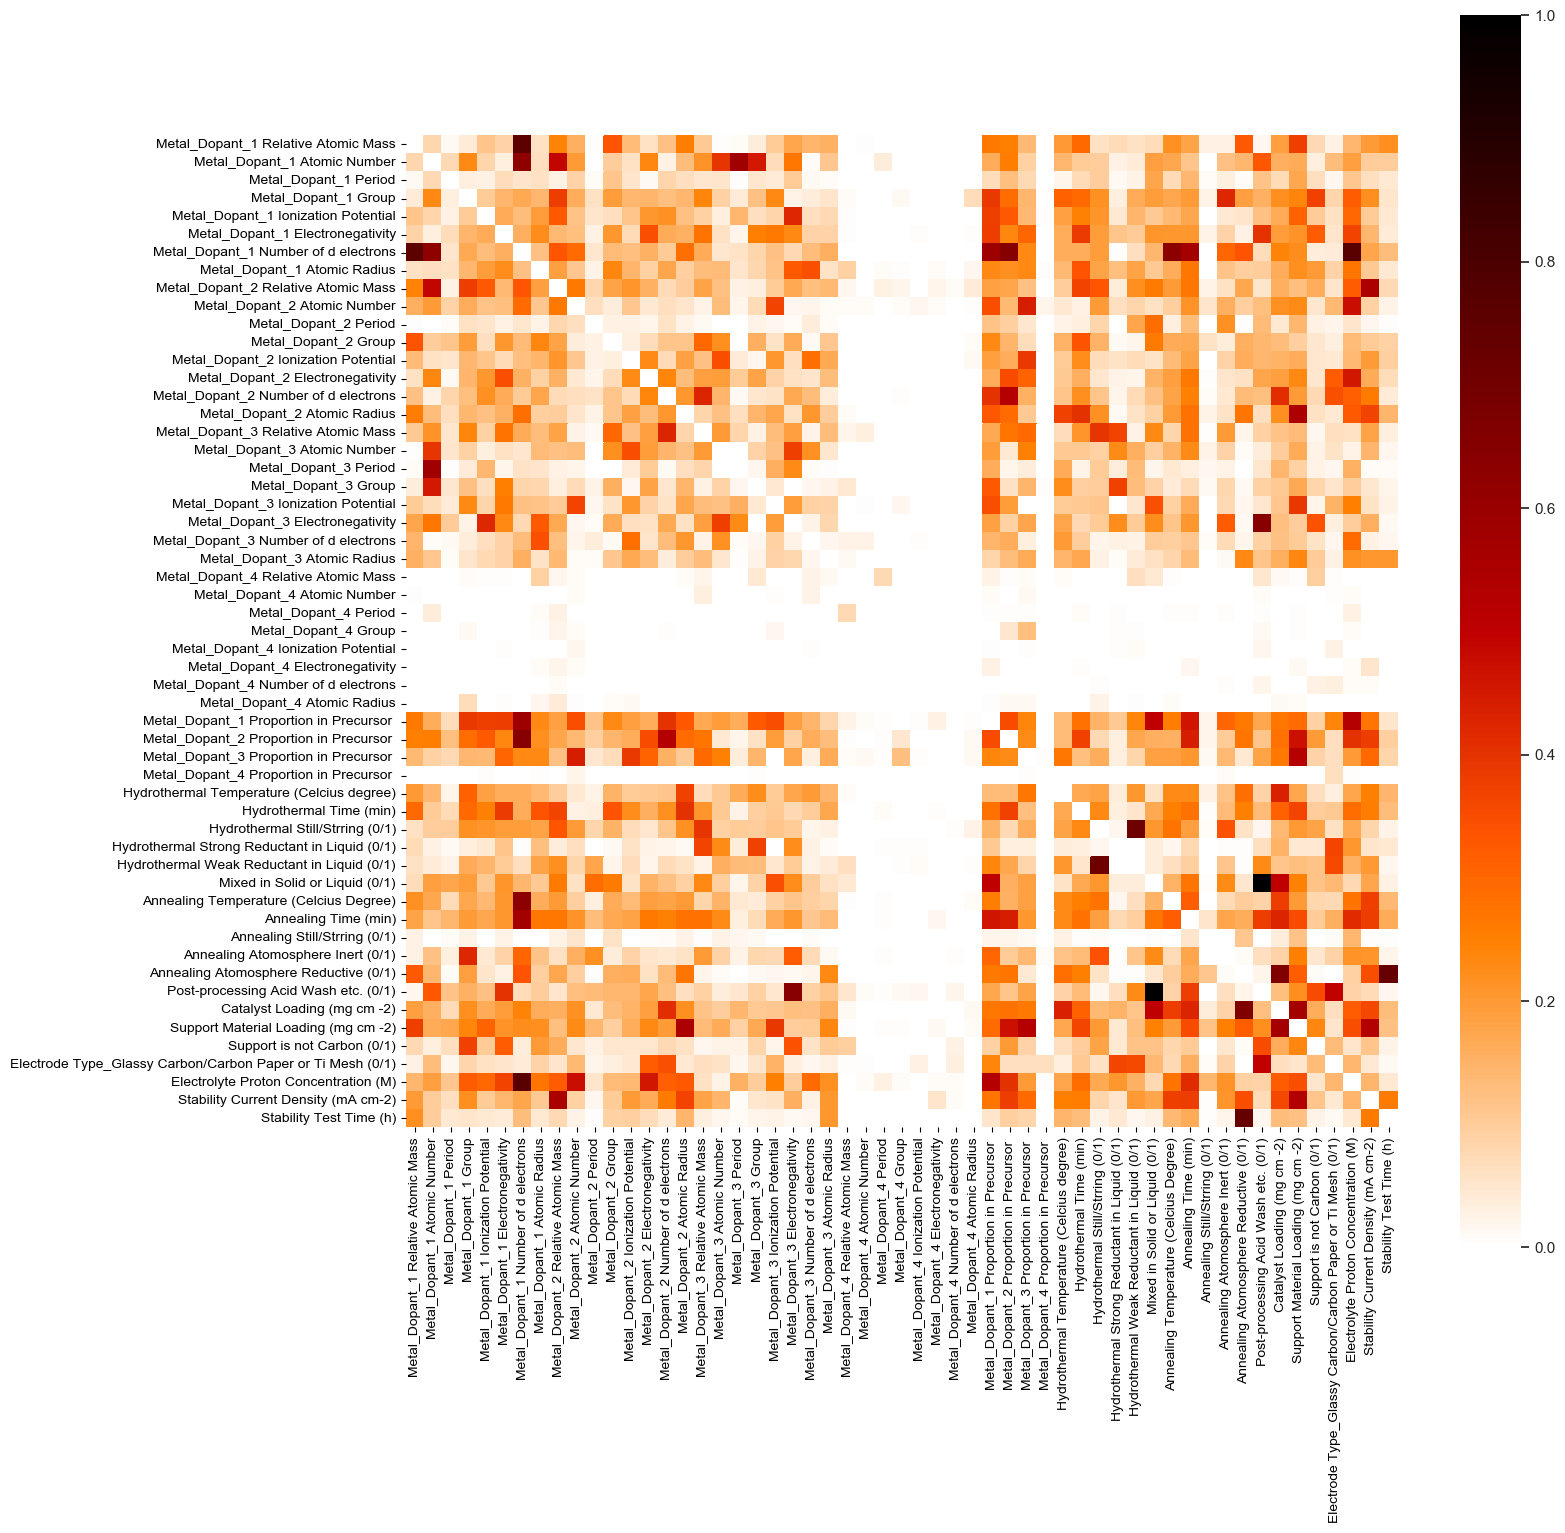

In [19]:
import seaborn as sns

f, ax= plt.subplots(figsize = (16, 16))
sns.set(font_scale=1)
ax=sns.heatmap(Weighted_Matrix,annot=False, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="gist_heat_r")

In [20]:
Element_M=Weighted_Matrix.iloc[0:36,0:36]
Synthesis_M=Weighted_Matrix.iloc[36:55,36:55]

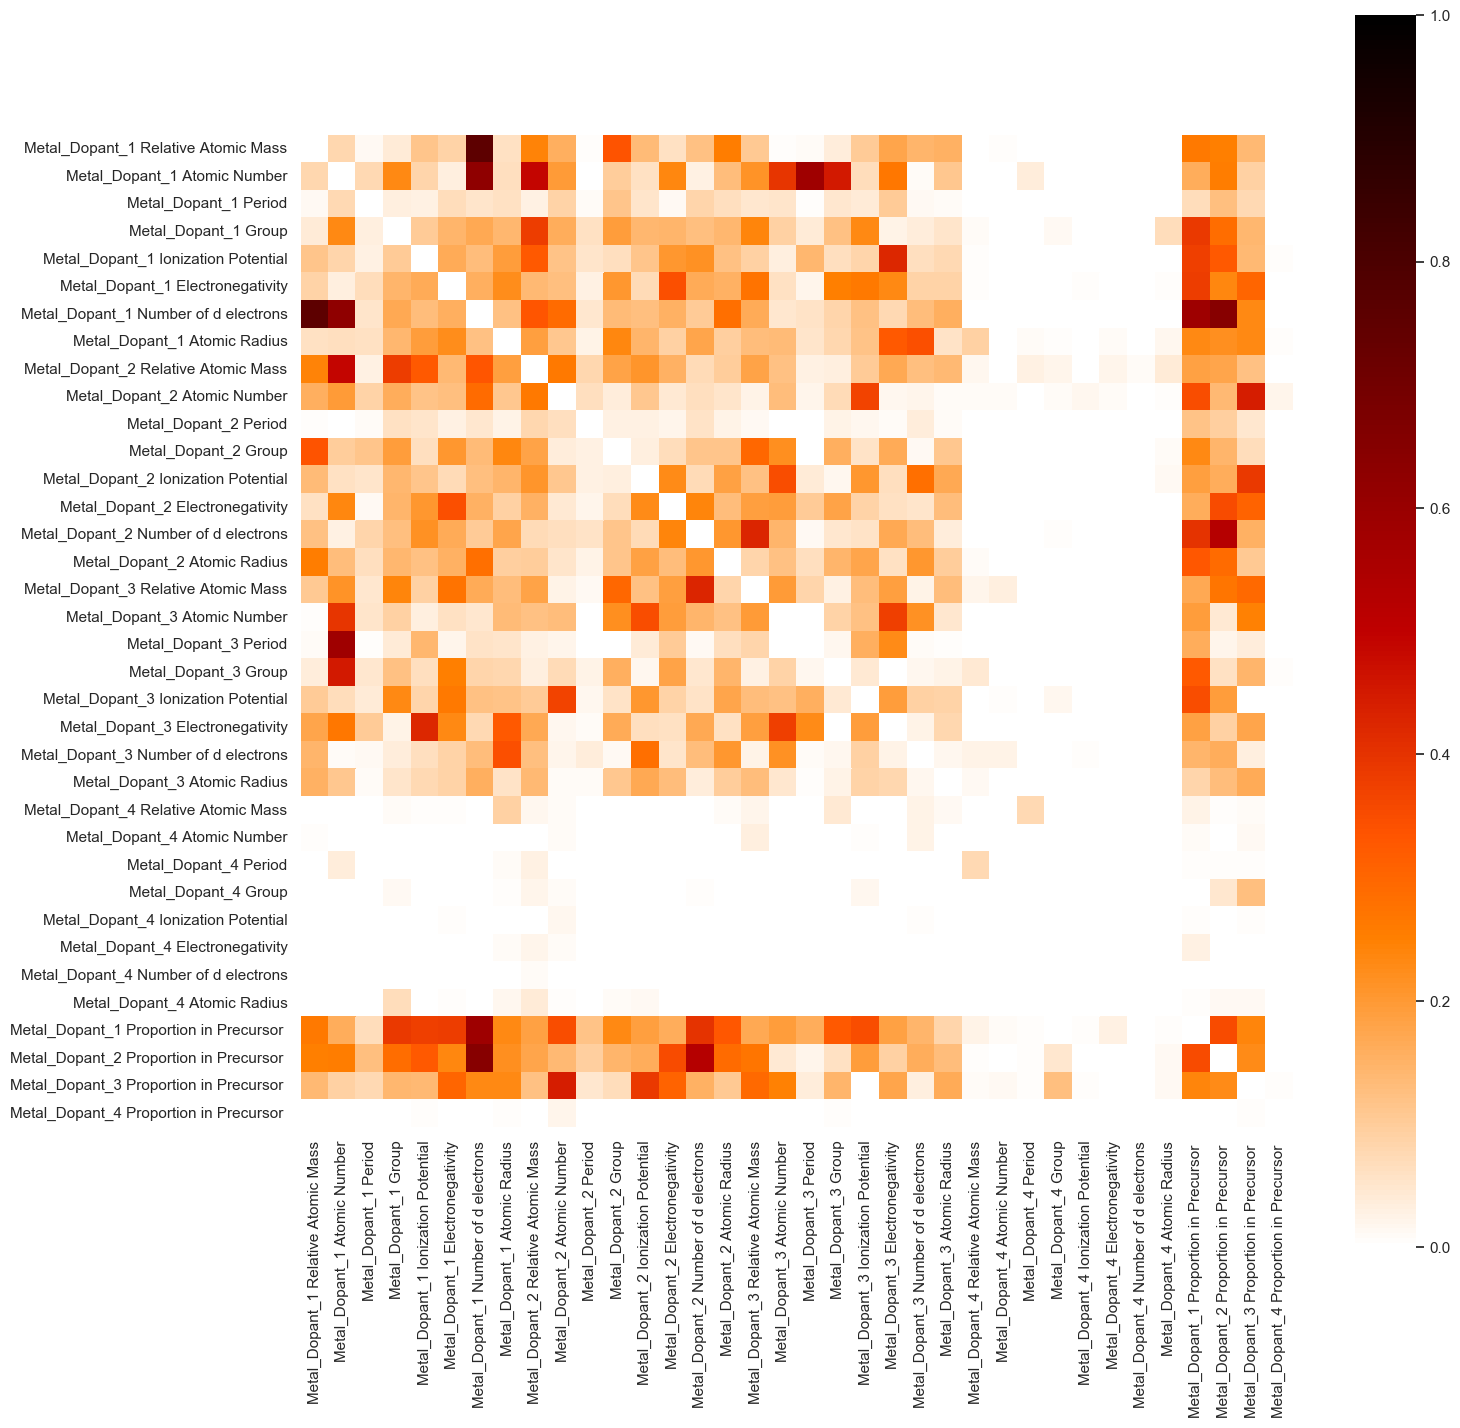

In [21]:
f1, ax1= plt.subplots(figsize = (16, 16))
# sns.set(font_scale=2)
ax1=sns.heatmap(Element_M,annot=False, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="gist_heat_r")

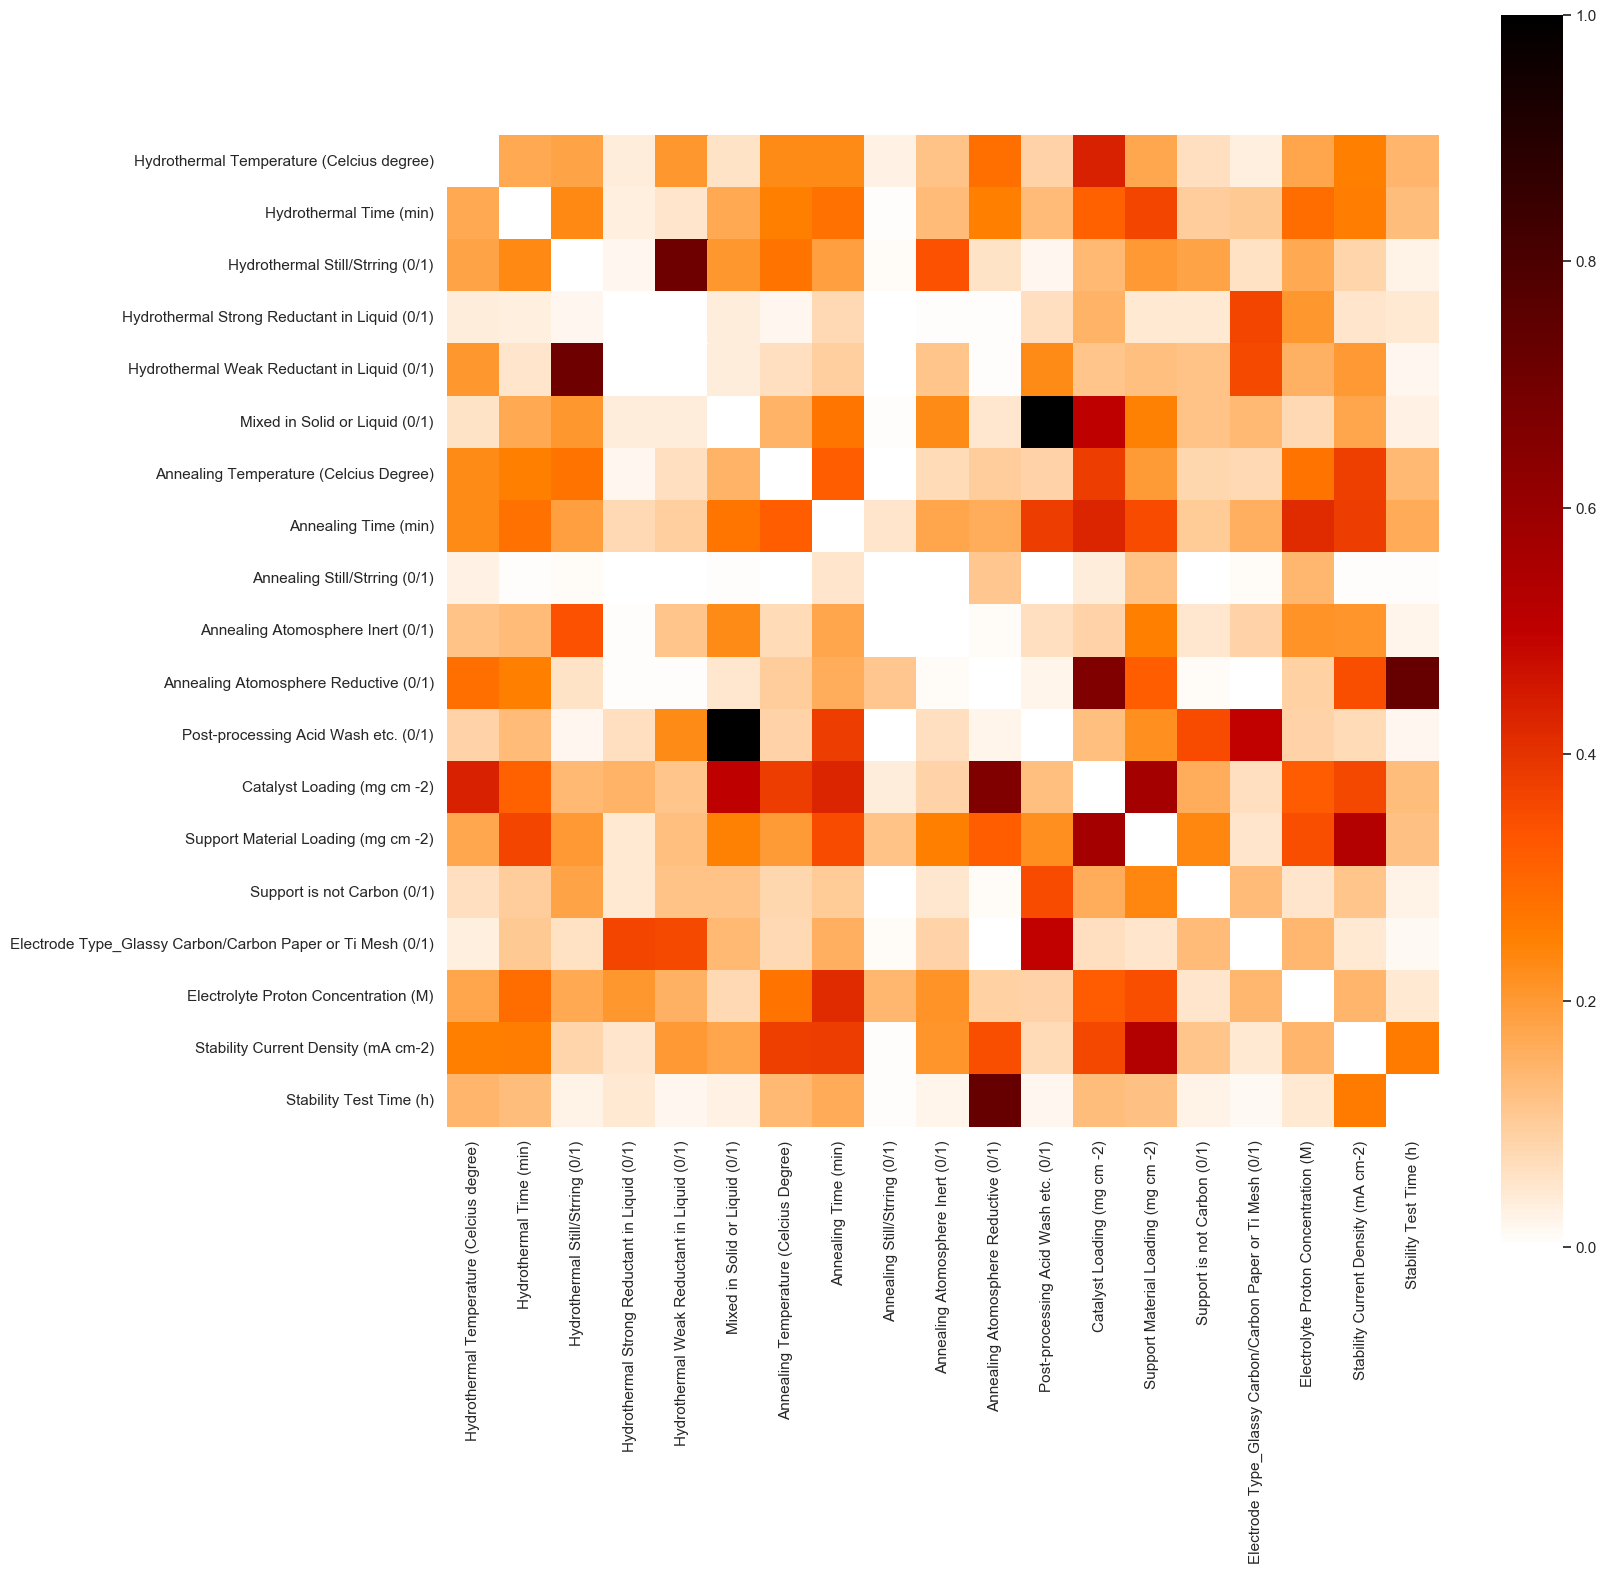

In [22]:
f2, ax2= plt.subplots(figsize = (16, 16))
# sns.set(font_scale=2)
ax2=sns.heatmap(Synthesis_M,annot=False, vmax=1,vmin = 0, xticklabels= True, yticklabels= True, square=True, cmap="gist_heat_r")